# Hyperparameters + Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import gc
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, LinearLocator, IndexLocator, FuncFormatter, NullFormatter
import numpy as np
import os
from os.path import join
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.models as models
import torchvision.transforms.functional as tv_F
from torchvision.datasets import MNIST

from improved_precision_recall import IPR

#model_type = 'diffusion'
model_type = 'wgan_gp'
w = 0

EPOCHS = 1000 + 1
SAMPLE_INTERVAL = 20
N_SAMPLES = np.ceil(EPOCHS/SAMPLE_INTERVAL).astype(int)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ROOT = join(#### your directory ##### , model_type)
ROOT = join(ROOT, f'{w=}') if model_type=='diffusion' else ROOT
METRICS_DIR = join(ROOT, 'metrics')
SAMPLES_DIR = join(ROOT, 'samples')
DATASETS_DIR = join(ROOT, 'datasets')

# Count the number of generations
N_generations = len(os.listdir(DATASETS_DIR)) // 2

2023-07-02 12:24:59.415093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 12:25:00.146155: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-02 12:25:00.146233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-02 12:25:00.146240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

#### Unused: Calculate FID-60K and PRDC

In [7]:
'''
# Get the real 60k training images from MNIST
real_train = MNIST(os.getcwd(), train=True, download=True).data.numpy()



generated_train_data = np.zeros((N_generations, 60000, 28, 28), dtype=np.uint8)

for i in tqdm(range(N_generations)):
    file = join(DATASETS_DIR, f'train_{i:03}.pt')
    dataset = torch.load(file)
    # generated_test_data[i] = ((dataset.tensors[0].numpy() + 1) / 2 * 255).astype(np.uint8).squeeze(1)
    generated_train_data[i] = dataset.tensors[0].numpy().squeeze(1)

train_labels = dataset.tensors[1].numpy().astype(np.uint8)
generated_train_data = torch.Tensor(generated_train_data).to(torch.uint8).unsqueeze(2)
real_train = torch.Tensor(real_train).to(torch.uint8).unsqueeze(1)



# TODO: Calculate the FID of each generation with respect to:
# a) The previous generation
# b) The real training data

train_fid_real = []

for g_i, generation in enumerate(tqdm(generated_train_data)):
    
    # Normalize=True -> images should be in [0, 1]
    # Normalize=False -> images should be in [0, 255]
    fid = FrechetInceptionDistance(normalize=False).to(device)

    batch = 50
    for i in range(len(train_labels) // batch):
        fid.update(torch.cat([real_train[int(i*batch):int(i+1)*batch]]*3, axis=1).to(device), real=True)
        fid.update(torch.cat([generation[int(i*batch):int(i+1)*batch]]*3, axis=1).to(device), real=False)
        
    train_fid_real.append(float(fid.compute().item()))
    del fid
    


np.savez('fid_60k_real.npz', train_fid_real=train_fid_real)
''';

100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [05:36<00:00,  3.33s/it]


# FID Plots

In [4]:
fid_real = np.zeros(N_generations, dtype=float)
fid_madc = np.zeros(N_generations, dtype=np.ndarray)

for g in range(N_generations):
    npz = np.load(join(METRICS_DIR, f'fid_{g:03}.npz'))
    fid_real[g] = npz['fid_real']
    fid_madc[g] = npz['fid_madc']

/tmp/ipykernel_274357/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1


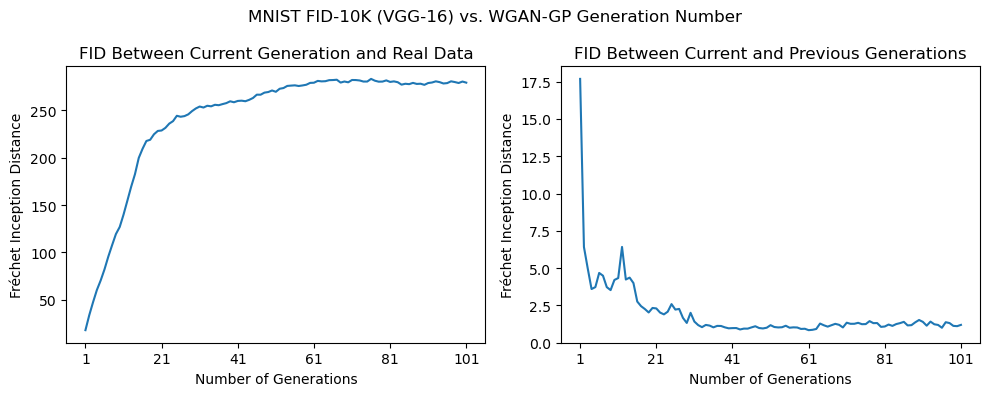

In [5]:
def xaxis_wrt_generation(axis, set_xlabel=True):
    if set_xlabel:
        axis.set_xlabel('Number of Generations')
    axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1
                          for item in axis.get_xticklabels()])

def add_qualifier(axis=plt):
    if model_type == 'diffusion':
        axis.set_title(f'MNIST Diffusion ({w=}): ' + axis.title._text)
    elif model_type == 'wgan_gp':
        axis.set_title(f'MNIST WGAN-GP: ' + axis.title._text)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
ax[0].plot(fid_real)
ax[0].set_ylabel('Fréchet Inception Distance')
xaxis_wrt_generation(ax[0])
ax[0].set_title('FID Between Current Generation and Real Data')
#add_qualifier(ax[0])

ax[1].plot([a.min() for a in fid_madc])
ax[1].set_ylabel('Fréchet Inception Distance')
xaxis_wrt_generation(ax[1])
ax[1].set_title('FID Between Current and Previous Generations')
#add_qualifier(ax[1])

fig.suptitle(f'MNIST FID-10K (VGG-16) vs. {"WGAN-GP" if model_type=="wgan_gp" else "Diffusion"} Generation Number')
fig.tight_layout()

In [10]:
print('generation, FID')
[print(f'{i+1}, {f:.2f}') for i, f in enumerate(fid_real)];

generation, FID
1, 18.08
2, 33.86
3, 47.61
4, 60.42
5, 70.50
6, 82.15
7, 95.61
8, 107.68
9, 119.40
10, 126.89
11, 139.88
12, 154.47
13, 169.23
14, 182.47
15, 199.68
16, 209.33
17, 217.53
18, 218.81
19, 224.62
20, 228.13
21, 228.60
22, 231.37
23, 235.82
24, 238.45
25, 244.09
26, 243.09
27, 243.76
28, 245.60
29, 249.04
30, 251.86
31, 253.85
32, 252.81
33, 254.67
34, 254.06
35, 255.68
36, 255.25
37, 256.42
38, 257.47
39, 259.37
40, 258.36
41, 259.74
42, 260.02
43, 259.45
44, 260.91
45, 262.88
46, 266.36
47, 266.34
48, 268.51
49, 269.14
50, 270.77
51, 269.41
52, 272.60
53, 273.34
54, 275.58
55, 275.92
56, 276.20
57, 275.51
58, 276.09
59, 276.84
60, 278.78
61, 278.95
62, 280.87
63, 280.38
64, 280.56
65, 281.65
66, 281.78
67, 282.12
68, 279.11
69, 280.23
70, 279.40
71, 281.83
72, 281.77
73, 281.33
74, 280.19
75, 280.21
76, 282.99
77, 281.09
78, 280.05
79, 280.16
80, 281.41
81, 279.80
82, 280.38
83, 279.50
84, 276.93
85, 277.87
86, 277.45
87, 278.79
88, 277.69
89, 277.91
90, 276.72
91, 278.64

/tmp/ipykernel_2740121/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1


Text(0.5, 1.0, 'MNIST FID-10K (VGG-16) vs. WGAN-GP Generation Number')

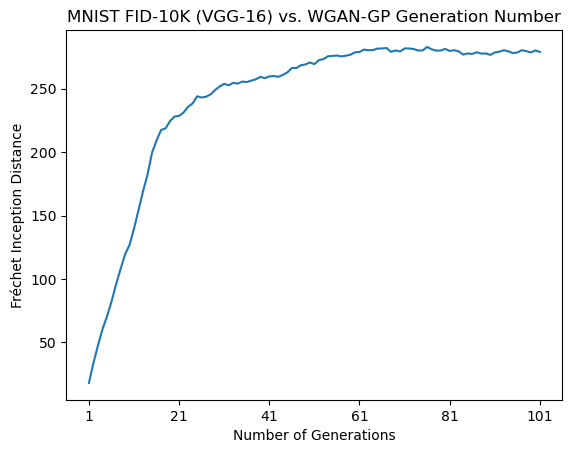

In [125]:
fig, ax = plt.subplots()
ax.plot(fid_real)
ax.set_ylabel('Fréchet Inception Distance')
xaxis_wrt_generation(ax)
ax.set_title(f'MNIST FID-10K (VGG-16) vs. {"WGAN-GP" if model_type=="wgan_gp" else "Diffusion"} Generation Number')

/tmp/ipykernel_2740121/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1


Text(0.5, 1.0, 'MNIST Relative FID-10K vs. WGAN-GP Generation Number')

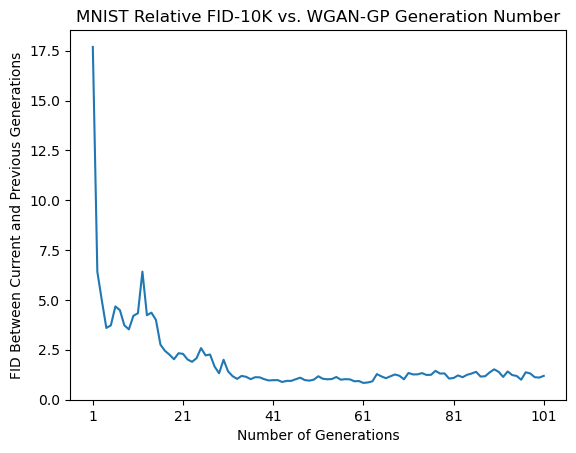

In [126]:
fig, ax = plt.subplots()

ax.plot([a.min() for a in fid_madc])
ax.set_ylabel('FID Between Current and Previous Generations')
xaxis_wrt_generation(ax)
ax.set_title(f'MNIST Relative FID-10K vs. {"WGAN-GP" if model_type=="wgan_gp" else "Diffusion"} Generation Number')

In [27]:
'''
# https://seaborn.pydata.org/tutorial/color_palettes.html
cmap = sns.color_palette('flare', n_colors=N_generations)

max_epoch = max([len(fids) for fids in fid_madc]) * SAMPLE_INTERVAL
mult = 2

fig, ax = plt.subplots()
for i in range(N_generations):
    sns.lineplot(fid_madc[i], c=cmap[i])#, label=f'Model {i}')
    
x_labels = np.arange(0, max_epoch, SAMPLE_INTERVAL*mult)
ax.set_xticks(np.arange(len(x_labels))*mult, labels=x_labels)
ax.set_xlabel('Epochs')
ax.set_ylabel('Inter-Generation FID')
ax.set_title(f'Inter-Generation FID vs. Epochs')
add_qualifier(ax)

# Add colorbar legend.
# See: https://matplotlib.org/3.4.3/gallery/ticks_and_spines/colorbar_tick_labelling_demo.html 
norm = plt.Normalize(1, N_generations) # [1, N_generations] inclusive
sm = plt.cm.ScalarMappable(cmap='flare_r', norm=norm)
sm.set_array([])
cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0, 0.05, ax.get_position().height])
cbar = ax.figure.colorbar(sm, cax=cax,
                          ticks=FixedLocator([1, N_generations]),
                          label='Model #')
cbar.ax.set_yticklabels([N_generations, 1]);
#cbar.ax.set_yticklabels(cbar.ax.get_yticklabels()[::-1]);
''';

In [22]:
'''
offset = 1

fig, ax = plt.subplots()
for i in range(N_generations):
    sns.lineplot(fid_madc[i][offset*mult:], c=cmap[i])
    sns.lineplot(x=[fid_madc[i].argmin() - offset*mult],
                 y=[fid_madc[i].min()], marker='*', markersize=15, c=cmap[i])
    
x_labels = np.arange(0, max_epoch, SAMPLE_INTERVAL*mult)[offset:]
ax.set_xticks(np.arange(len(x_labels))*mult, labels=x_labels)
ax.set_xlabel('Epochs')
ax.set_ylabel('Inter-Generation FID')
ax.set_title(f'Inter-Generation FID vs. Epochs, r={r} (zoomed in)')

# Add colorbar legend.
# See: https://matplotlib.org/3.4.3/gallery/ticks_and_spines/colorbar_tick_labelling_demo.html 
norm = plt.Normalize(1, N_generations) # [1, N_generations] inclusive
sm = plt.cm.ScalarMappable(cmap='flare_r', norm=norm)
sm.set_array([])
cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0, 0.05, ax.get_position().height])
cbar = ax.figure.colorbar(sm, cax=cax,
                          ticks=FixedLocator(x_axis),
                          label='Model #')
cbar.ax.set_yticklabels(x_axis[::-1]);
''';

# Datasets

In [6]:
generated_data = np.zeros((N_generations, 60000, 28, 28), dtype=np.uint8)

for i in tqdm(range(N_generations)):
    file = join(DATASETS_DIR, f'train_{i:03}.pt')
    dataset = torch.load(file)
    generated_data[i] = dataset.tensors[0].numpy().squeeze(1)
    
mnist_labels = dataset.tensors[1].numpy().astype(np.uint8)

100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [06:50<00:00,  4.07s/it]


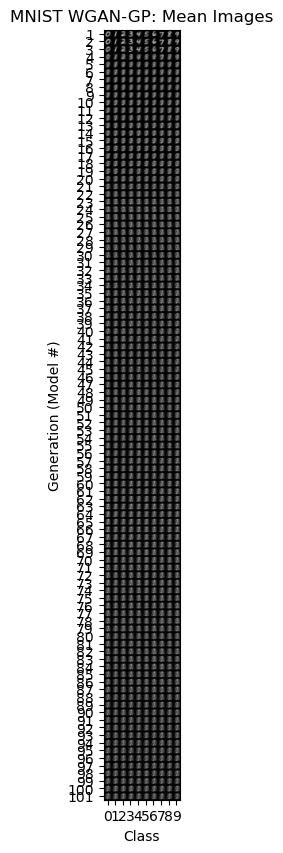

In [6]:
mean_imgs = np.zeros((N_generations, 10, 28, 28), dtype=np.uint8)

for num in range(10):
    # Get the indices of all images with label 'num'
    indices = np.where(mnist_labels == num)[0]
    for i in range(N_generations):
        # Take the mean of all images with the same label
        mean_imgs[i, num] = generated_data[i][indices].mean(axis=0)
        
# Code to display the mean images as a PIL Image:
#print(f'Mean Images per Class, r={r}:')
#Image.fromarray(np.vstack([np.hstack([img for img in generation]) for generation in mean_imgs]))

def plot_means(means):
    # Code to display the mean images as a pyplot:
    fig, ax = plt.subplots(figsize=(5, 10))
    ax.set_title(f'Mean Images')
    add_qualifier(ax)
    #ax.imshow(np.vstack([np.hstack([img for img in generation]) for generation in mean_imgs]),
    #          cmap='gray')
    ax.imshow(np.vstack([np.hstack(gen) for gen in means]), cmap='gray')
    
    ax.set_ylabel('Generation (Model #)')
    ax.set_yticks(28//2 + np.arange(len(means)) * 28)
    ax.set_yticklabels(np.arange(len(means)) + 1)

    ax.set_xlabel('Class')
    ax.set_xticks(28//2 + np.arange(10)*28)
    ax.set_xticklabels(range(10))
    return ax
    
plot_means(mean_imgs);

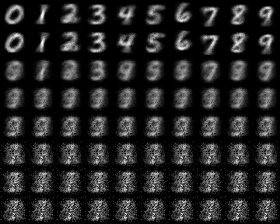

In [7]:
idx = np.array([1,2,4,8,16,32,64,101])
Image.fromarray(np.vstack([np.hstack(m) for m in mean_imgs[idx-1]]))

In [8]:
# New version:

total_variance = generated_data.var(axis=1).sum(axis=(1,2))

imgs_var = np.zeros((N_generations, 10))

for num in range(10):
    # Get the indices of all images with label 'num'
    indices = np.where(mnist_labels == num)[0]
    for i in range(N_generations):
        # Take the variance of all images with the same label
        imgs_var[i, num] = generated_data[i][indices].var(axis=0).sum()

/tmp/ipykernel_14057/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1
/tmp/ipykernel_14057/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1


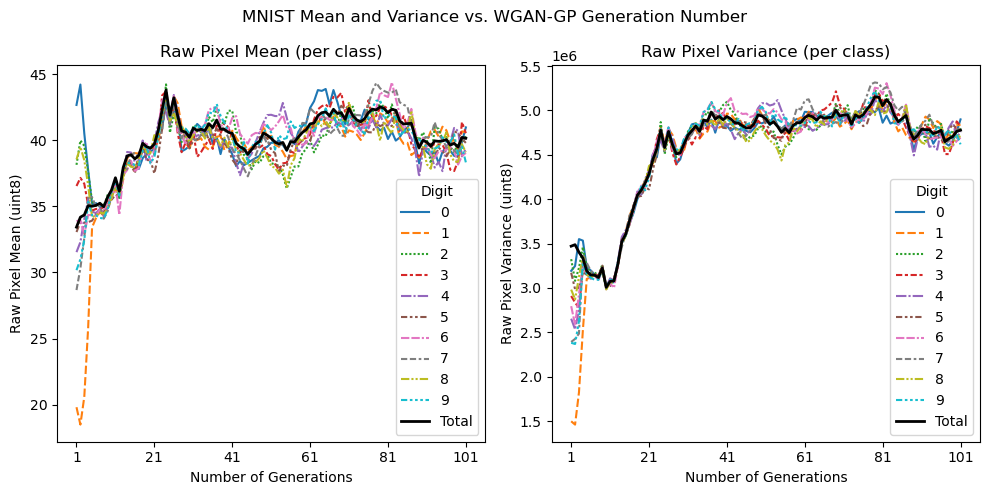

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

sns.lineplot(mean_imgs.mean(axis=(2,3)), ax=ax[0])
sns.lineplot(generated_data.mean(axis=(1,2,3)), # equivalent to .mean(axis=1).mean(axis=(1,2)),
             linewidth=2, c='black', label='Total', ax=ax[0])
ax[0].set_title(f'Raw Pixel Mean (per class)')
#add_qualifier(ax[0])
xaxis_wrt_generation(ax[0])
ax[0].set_ylabel('Raw Pixel Mean (uint8)')
ax[0].legend(title='Digit')#, fancybox=True)

sns.lineplot(imgs_var, ax=ax[1])
sns.lineplot(total_variance, linewidth=2, c='black', label='Total', ax=ax[1])
ax[1].set_title(f'Raw Pixel Variance (per class)')
#add_qualifier(ax[1])
xaxis_wrt_generation(ax[1])
ax[1].set_ylabel('Raw Pixel Variance (uint8)')
ax[1].legend(title='Digit')

plt.suptitle(f'MNIST Mean and Variance vs. {"WGAN-GP" if model_type=="wgan_gp" else "Diffusion"} Generation Number')
plt.tight_layout()
plt.show()

# Samples

In [10]:
N_per_class = 5
#labels = dataset.tensors[1].numpy().astype(np.uint8)
indices = np.hstack([np.where(mnist_labels == i)[0][:N_per_class] for i in range(10)])
big_img = np.vstack([np.hstack(generated_data[g, indices]) for g in range(N_generations)])

def plot_samples(sample_arr):
    fig, ax = plt.subplots(figsize=(15, 30))
    ax.imshow(sample_arr, cmap='gray')
    ax.set_title(f'{N_per_class} Samples per Class per Generation')
    add_qualifier(ax)
    ax.set_ylabel('Generation (Model #)')
    ax.set_yticks(28//2 + np.arange(N_generations) * 28)
    ax.set_yticklabels(np.arange(N_generations) + 1)

    # xaxis code taken from https://matplotlib.org/3.1.1/gallery/ticks_and_spines/tick-locators.html
    ax.xaxis.set_major_locator(LinearLocator(11))
    ax.xaxis.set_minor_locator(IndexLocator(base=N_per_class*28, offset=N_per_class*28//2))

    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(FuncFormatter(lambda x, pos: f'Class {pos}'))

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')
        
    return ax
        
#plot_samples(big_img);

[  1   2   4   8  16  32  64 101]


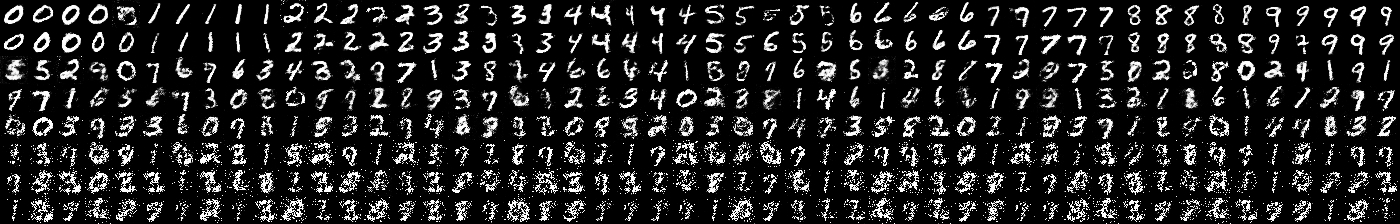

In [11]:
print(idx)
Image.fromarray(np.vstack([np.hstack(generated_data[g, indices]) for g in idx-1]))

# Classifier-Based Metrics

In [12]:
model_location = join('/mnt', 'richb', 'josue', 'Madcow', 'resnet18_mnist.pt')

### Classifier Loading / Training

In [13]:
# Taken from https://zablo.net/blog/post/pytorch-resnet-mnist-jupyter-notebook-2021/

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torch import nn
from torch.utils.data import DataLoader

import pytorch_lightning as pl

class ResNetMNIST(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # define model and loss
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.loss = nn.CrossEntropyLoss()

    #@auto_move_data # this decorator automatically handles moving your tensors to GPU if required
    def forward(self, x):
        return self.model(x)
  
    def training_step(self, batch, batch_no):
        # implement single training step
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss
  
    def configure_optimizers(self):
        # choose your optimizer
        return torch.optim.RMSprop(self.parameters(), lr=0.005)
    
    
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [14]:
if os.path.isfile(model_location):
    model = ResNetMNIST.load_from_checkpoint(model_location, map_location=device)
    model = model.to(device)
    
else:
    # NOTE: transforms.ToTensor() does the following:
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    train_ds = MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
    test_ds = MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=64)

    torch.manual_seed(1)

    model = ResNetMNIST()
    trainer = pl.Trainer(
        accelerator='gpu',
        devices=[int(device[-1])], #use device
        max_epochs=3 # set number of epochs
    )
    trainer.fit(model, train_dl)

    true_y, pred_y = [], []
    for batch in iter(test_dl):
        x, y = batch
        true_y.extend(y)
        preds, probs = get_prediction(x, model)
        pred_y.extend(preds.cpu())

    from sklearn.metrics import classification_report
    print(classification_report(true_y, pred_y, digits=3))

    trainer.save_checkpoint(model_location)

### Calculating metrics

In [15]:
pred_classes = np.zeros((N_generations, 60000), dtype=np.uint8) # Class predictions
prob_classes = np.zeros((N_generations, 60000, 10)) # Class probabilities
num_occurrences = np.zeros((N_generations, 10))

for g in tqdm(range(N_generations)):
    tensor_imgs = torch.cat([transforms.ToTensor()(img).unsqueeze(0) for img in generated_data[g]])
    t1, t2 = get_prediction(tensor_imgs.to(device), model) # Get tensors 1 and 2
    pred_classes[g] = t1.cpu().numpy() # First tensor is predicted class
    prob_classes[g] = t2.cpu().numpy() # Second tensor is probability of class
    classes, counts = np.unique(pred_classes[g], return_counts=True)
    num_occurrences[g, classes] = counts
    
del model
gc.collect()
torch.cuda.empty_cache()

100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [18:17<00:00, 10.87s/it]


/tmp/ipykernel_14057/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1


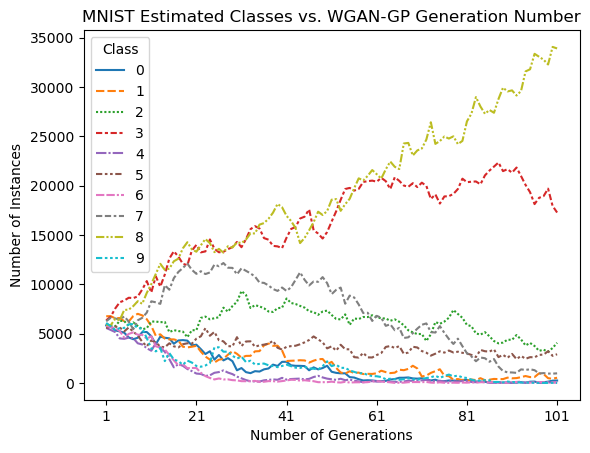

In [16]:
ax = sns.lineplot(num_occurrences)
ax.set_title(f'MNIST Estimated Classes vs. {"WGAN-GP" if model_type=="wgan_gp" else "Diffusion"} Generation Number')
#add_qualifier(ax)
ax.set_ylabel('Number of Instances')
ax.set_xlabel('Generation (Model #)')
xaxis_wrt_generation(ax)
ax.legend(title='Class');

In [23]:
# Convert to dataframe and save as .csv
pd.DataFrame(num_occurrences).to_csv('mnist_gan_classes')

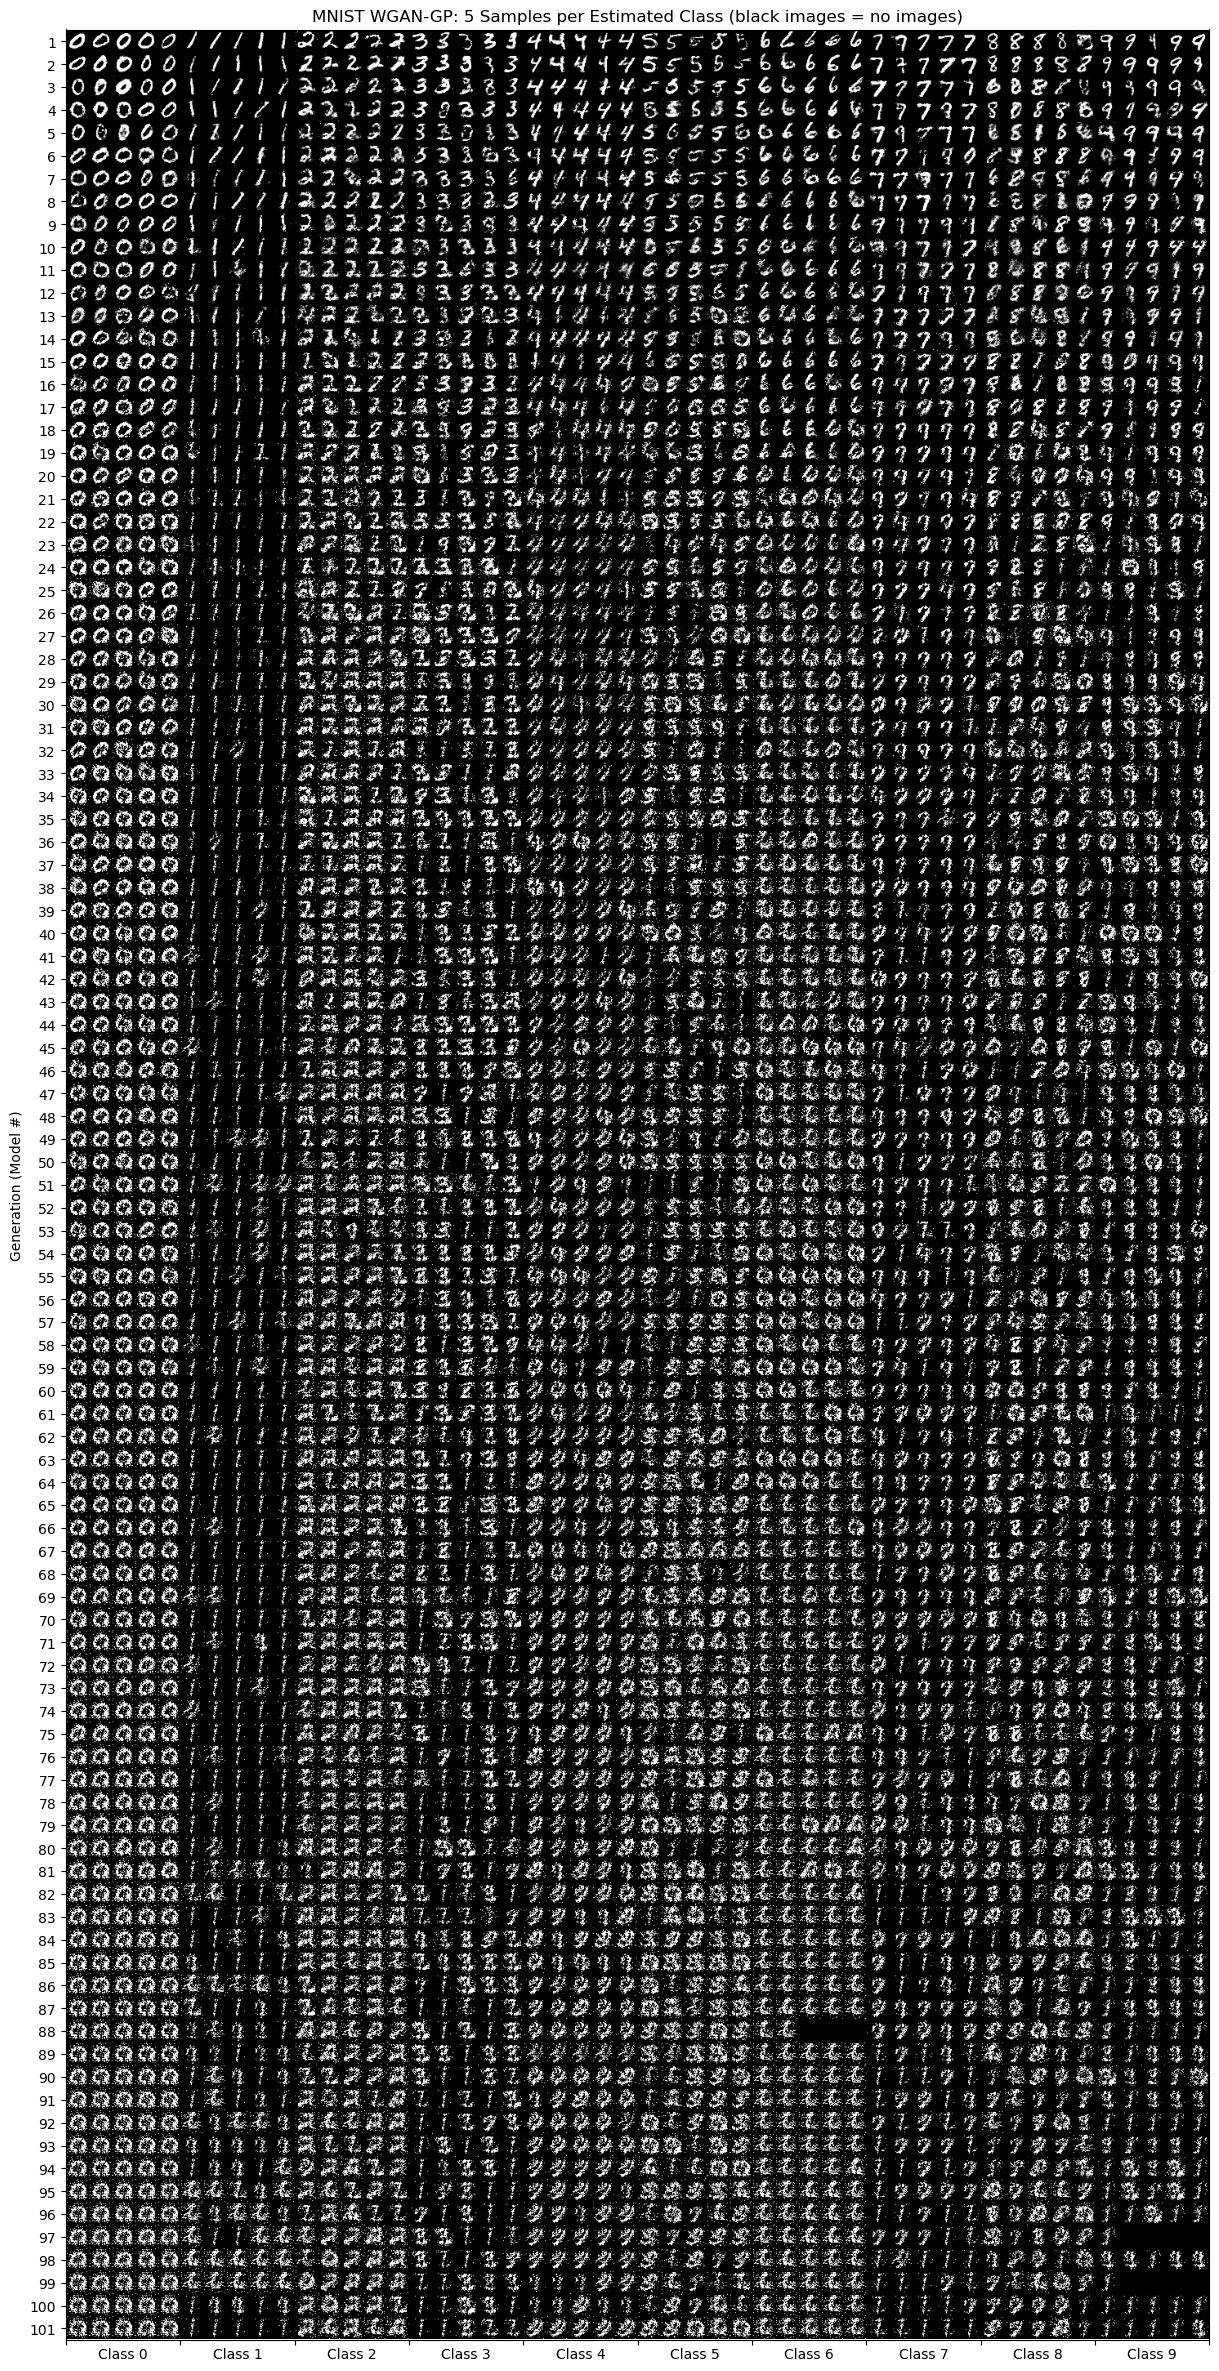

In [84]:
N_per_class = 5
big_img = np.zeros((28*N_generations, 28*N_per_class*10),   dtype=np.uint8)
mean_estimated_imgs = np.zeros((N_generations, 10, 28, 28), dtype=np.uint8)

for g in range(N_generations):
    for digit in range(10):
        imgs = generated_data[g][pred_classes[g] == digit] #[:N_per_class]
        mean_estimated_imgs[g, digit] = imgs.mean(axis=0) # Calculate the mean image of each estimated class
        # Keep the first N_per_class images from each estimated class
        imgs = imgs[:N_per_class]
        # Zero-pad any missing images
        if len(imgs) < N_per_class:
            imgs = np.vstack([imgs, np.zeros((N_per_class - len(imgs), 28, 28))])
    
        big_img[28*g:28*(g+1), 28*digit*N_per_class:28*(digit+1)*N_per_class] = np.hstack(imgs)
        
ax = plot_samples(big_img)
ax.set_title(f'5 Samples per Estimated Class (black images = no images)')
add_qualifier(ax)

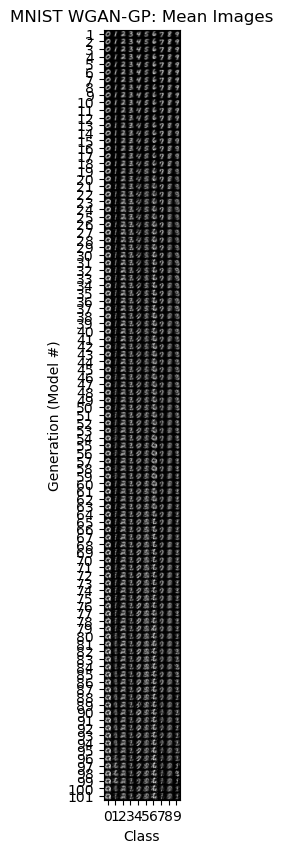

In [85]:
ax = plot_means(mean_estimated_imgs);

/tmp/ipykernel_2740121/554334161.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1


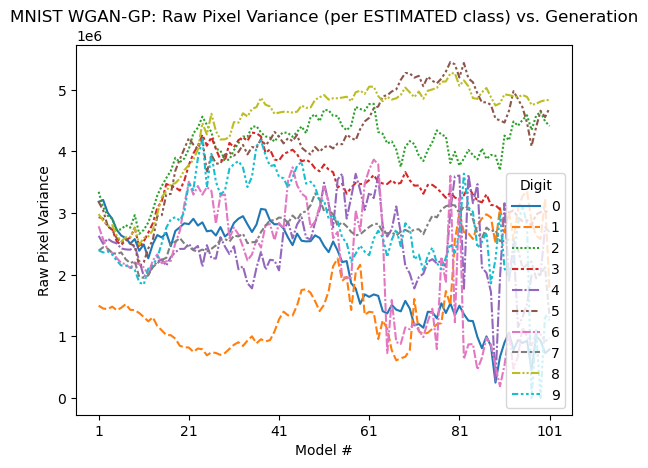

In [90]:
# Plotting the "estimated class"-wise variance

estimated_class_variance = np.zeros((N_generations, 10))

for g in range(N_generations):
    for digit in range(10):
        estimated_class_variance[g, digit] = generated_data[g, pred_classes[g] == digit].var(axis=0).sum()
        

ax = sns.lineplot(estimated_class_variance)
#ax.set_title(f'Raw Pixel Variance (per ESTIMATED class) vs. Generation, r={r}')

#sns.lineplot(total_variance, linewidth=2, c='black', label='Total', ax=ax)
ax.set_title(f'Raw Pixel Variance (per ESTIMATED class) vs. Generation')
add_qualifier(ax)
xaxis_wrt_generation(ax)
ax.set_xlabel('Model #')
ax.set_ylabel('Raw Pixel Variance')
ax.legend(title='Digit');

# Precision / Recall
https://github.com/youngjung/improved-precision-and-recall-metric-pytorch 

https://github.com/clovaai/generative-evaluation-prdc

In [7]:
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms.functional as tv_F
from torchvision.datasets import MNIST
from improved_precision_recall import IPR

In [8]:
# Get the real 10k test images from MNIST
real_test = MNIST(os.getcwd(), train=False, download=True).data.numpy()

In [9]:
generated_test_data = np.zeros((N_generations, 10000, 28, 28), dtype=np.uint8)

for i in tqdm(range(N_generations)):
    file = join(DATASETS_DIR, f'test_{i:03}.pt')
    dataset = torch.load(file)
    # generated_test_data[i] = ((dataset.tensors[0].numpy() + 1) / 2 * 255).astype(np.uint8).squeeze(1)
    generated_test_data[i] = dataset.tensors[0].numpy().squeeze(1)

test_labels = dataset.tensors[1].numpy().astype(np.uint8)

100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:21<00:00,  4.67it/s]


In [10]:
def ipr_preprocess(array):
    '''
    Preprocess an array (numpy or torch) of images (B x H x W) (no channels) in the same way as IPR.
    Return a Tensor of preprocessed images.
    See get_custom_loader function from IPR:
    https://github.com/youngjung/improved-precision-and-recall-metric-pytorch/blob/master/improved_precision_recall.py
    '''
    tensor = torch.from_numpy(array) if isinstance(array, np.ndarray) else array
    tensor = tensor.unsqueeze(1) # Add Channel dimension
    tensor = F.interpolate(tensor, [224, 224])
    tensor = tensor - tensor.min() # Normalize to [0, 1], as in transforms.toTensor
    tensor = tensor / tensor.max() # Normalize to [0, 1], as in transforms.toTensor
    tensor = torch.cat([tensor] * 3, axis=1)
    tensor = tv_F.normalize(tensor,
                            mean = torch.Tensor([[[0.485]], [[0.456]], [[0.406]]]),
                            std  = torch.Tensor([[[0.229]], [[0.224]], [[0.225]]]))
    return tensor

torch.cuda.empty_cache()
# Note: IPR expects num_samples=10k by default
# ipr = IPR(batch_size=10, model=models.vgg16(pretrained=True).to(device).eval())
ipr = IPR(batch_size=10)

ipr.compute_manifold_ref(ipr_preprocess(real_test).to(device))

loading vgg16 for improved precision and recall...

/home/josue/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/josue/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


done


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.62it/s]


In [11]:
# New code (Precision, Recall, Density and Coverage)

from prdc import compute_prdc

precision = np.zeros(N_generations)
density   = np.zeros(N_generations)
recall    = np.zeros(N_generations)
coverage  = np.zeros(N_generations)

for g in range(N_generations):
    print(f'Generation {g}')
    feat_fake = ipr.extract_features(ipr_preprocess(generated_test_data[g]).to(device))
    metric = compute_prdc(real_features=ipr.manifold_ref.features,
                          fake_features=feat_fake,
                          nearest_k=3) # Precision/Recall typically uses k=3
    precision[g] = metric['precision']
    recall[g]    = metric['recall']
    '''
    metric = compute_prdc(real_features=ipr.manifold_ref.features,
                          fake_features=feat_fake,
                          nearest_k=5) # Density/Coverage provably uses k=5
    density[g]   = metric['density']
    coverage[g]  = metric['coverage']
    ''';

Generation 0


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


Num real: 10000 Num fake: 10000
Generation 1


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.30it/s]


Num real: 10000 Num fake: 10000
Generation 2


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.25it/s]


Num real: 10000 Num fake: 10000
Generation 3


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.17it/s]


Num real: 10000 Num fake: 10000
Generation 4


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.19it/s]


Num real: 10000 Num fake: 10000
Generation 5


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 6


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 7


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.10it/s]


Num real: 10000 Num fake: 10000
Generation 8


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 9


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.96it/s]


Num real: 10000 Num fake: 10000
Generation 10


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.00it/s]


Num real: 10000 Num fake: 10000
Generation 11


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.97it/s]


Num real: 10000 Num fake: 10000
Generation 12


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.02it/s]


Num real: 10000 Num fake: 10000
Generation 13


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.01it/s]


Num real: 10000 Num fake: 10000
Generation 14


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


Num real: 10000 Num fake: 10000
Generation 15


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


Num real: 10000 Num fake: 10000
Generation 16


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.02it/s]


Num real: 10000 Num fake: 10000
Generation 17


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.00it/s]


Num real: 10000 Num fake: 10000
Generation 18


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.04it/s]


Num real: 10000 Num fake: 10000
Generation 19


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.01it/s]


Num real: 10000 Num fake: 10000
Generation 20


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.02it/s]


Num real: 10000 Num fake: 10000
Generation 21


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.96it/s]


Num real: 10000 Num fake: 10000
Generation 22


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.94it/s]


Num real: 10000 Num fake: 10000
Generation 23


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.96it/s]


Num real: 10000 Num fake: 10000
Generation 24


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


Num real: 10000 Num fake: 10000
Generation 25


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.94it/s]


Num real: 10000 Num fake: 10000
Generation 26


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.01it/s]


Num real: 10000 Num fake: 10000
Generation 27


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


Num real: 10000 Num fake: 10000
Generation 28


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.01it/s]


Num real: 10000 Num fake: 10000
Generation 29


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.06it/s]


Num real: 10000 Num fake: 10000
Generation 30


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.02it/s]


Num real: 10000 Num fake: 10000
Generation 31


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.00it/s]


Num real: 10000 Num fake: 10000
Generation 32


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.01it/s]


Num real: 10000 Num fake: 10000
Generation 33


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 34


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.00it/s]


Num real: 10000 Num fake: 10000
Generation 35


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 36


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 37


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.00it/s]


Num real: 10000 Num fake: 10000
Generation 38


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


Num real: 10000 Num fake: 10000
Generation 39


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 40


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 41


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 42


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 43


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 44


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 45


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 46


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


Num real: 10000 Num fake: 10000
Generation 47


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.96it/s]


Num real: 10000 Num fake: 10000
Generation 48


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.04it/s]


Num real: 10000 Num fake: 10000
Generation 49


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.03it/s]


Num real: 10000 Num fake: 10000
Generation 50


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.02it/s]


Num real: 10000 Num fake: 10000
Generation 51


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 52


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 53


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.09it/s]


Num real: 10000 Num fake: 10000
Generation 54


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 55


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 56


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.98it/s]


Num real: 10000 Num fake: 10000
Generation 57


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.10it/s]


Num real: 10000 Num fake: 10000
Generation 58


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 59


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 60


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.10it/s]


Num real: 10000 Num fake: 10000
Generation 61


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 62


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.10it/s]


Num real: 10000 Num fake: 10000
Generation 63


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.06it/s]


Num real: 10000 Num fake: 10000
Generation 64


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 65


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.01it/s]


Num real: 10000 Num fake: 10000
Generation 66


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.06it/s]


Num real: 10000 Num fake: 10000
Generation 67


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 68


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.06it/s]


Num real: 10000 Num fake: 10000
Generation 69


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.09it/s]


Num real: 10000 Num fake: 10000
Generation 70


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.09it/s]


Num real: 10000 Num fake: 10000
Generation 71


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 72


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.06it/s]


Num real: 10000 Num fake: 10000
Generation 73


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 74


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 75


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 76


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.04it/s]


Num real: 10000 Num fake: 10000
Generation 77


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.04it/s]


Num real: 10000 Num fake: 10000
Generation 78


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.04it/s]


Num real: 10000 Num fake: 10000
Generation 79


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 80


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.09it/s]


Num real: 10000 Num fake: 10000
Generation 81


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 82


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.06it/s]


Num real: 10000 Num fake: 10000
Generation 83


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 84


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 85


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 86


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.08it/s]


Num real: 10000 Num fake: 10000
Generation 87


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.06it/s]


Num real: 10000 Num fake: 10000
Generation 88


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.02it/s]


Num real: 10000 Num fake: 10000
Generation 89


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.02it/s]


Num real: 10000 Num fake: 10000
Generation 90


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 91


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.09it/s]


Num real: 10000 Num fake: 10000
Generation 92


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000
Generation 93


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 94


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.07it/s]


Num real: 10000 Num fake: 10000
Generation 95


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.11it/s]


Num real: 10000 Num fake: 10000
Generation 96


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.06it/s]


Num real: 10000 Num fake: 10000
Generation 97


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.04it/s]


Num real: 10000 Num fake: 10000
Generation 98


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.10it/s]


Num real: 10000 Num fake: 10000
Generation 99


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.09it/s]


Num real: 10000 Num fake: 10000
Generation 100


extracting features of 10000 images: 100%|██████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.05it/s]


Num real: 10000 Num fake: 10000


In [28]:
print('generation, recall')
[print(f'{i+1}, {r:.4f}') for i, r in enumerate(recall)];

generation, recall
1, 0.5455
2, 0.3738
3, 0.3000
4, 0.2568
5, 0.1711
6, 0.1136
7, 0.0745
8, 0.0532
9, 0.0295
10, 0.0144
11, 0.0109
12, 0.0044
13, 0.0013
14, 0.0018
15, 0.0019
16, 0.0028
17, 0.0026
18, 0.0015
19, 0.0009
20, 0.0004
21, 0.0003
22, 0.0001
23, 0.0001
24, 0.0000
25, 0.0001
26, 0.0001
27, 0.0000
28, 0.0001
29, 0.0001
30, 0.0000
31, 0.0000
32, 0.0005
33, 0.0000
34, 0.0000
35, 0.0000
36, 0.0000
37, 0.0000
38, 0.0001
39, 0.0000
40, 0.0000
41, 0.0003
42, 0.0000
43, 0.0000
44, 0.0000
45, 0.0000
46, 0.0000
47, 0.0000
48, 0.0000
49, 0.0000
50, 0.0000
51, 0.0000
52, 0.0000
53, 0.0000
54, 0.0000
55, 0.0000
56, 0.0000
57, 0.0000
58, 0.0000
59, 0.0000
60, 0.0000
61, 0.0000
62, 0.0000
63, 0.0000
64, 0.0000
65, 0.0000
66, 0.0000
67, 0.0000
68, 0.0000
69, 0.0000
70, 0.0000
71, 0.0000
72, 0.0000
73, 0.0000
74, 0.0000
75, 0.0000
76, 0.0000
77, 0.0000
78, 0.0000
79, 0.0000
80, 0.0000
81, 0.0000
82, 0.0000
83, 0.0000
84, 0.0000
85, 0.0000
86, 0.0000
87, 0.0000
88, 0.0000
89, 0.0000
90, 0.0000


In [33]:
print('generation, log-recall')
[print(f'{i}, {np.log(r):.2f}') for i, r in enumerate(recall)];

generation, log-recall
0, -0.61
1, -0.98
2, -1.20
3, -1.36
4, -1.77
5, -2.18
6, -2.60
7, -2.93
8, -3.52
9, -4.24
10, -4.52
11, -5.43
12, -6.65
13, -6.32
14, -6.27
15, -5.88
16, -5.95
17, -6.50
18, -7.01
19, -7.82
20, -8.11
21, -9.21
22, -9.21
23, -inf
24, -9.21
25, -9.21
26, -inf
27, -9.21
28, -9.21
29, -inf
30, -inf
31, -7.60
32, -inf
33, -inf
34, -inf
35, -inf
36, -inf
37, -9.21
38, -inf
39, -inf
40, -8.11
41, -inf
42, -inf
43, -inf
44, -inf
45, -inf
46, -inf
47, -inf
48, -inf
49, -inf
50, -inf
51, -inf
52, -inf
53, -inf
54, -inf
55, -inf
56, -inf
57, -inf
58, -inf
59, -inf
60, -inf
61, -inf
62, -inf
63, -inf
64, -inf
65, -inf
66, -inf
67, -inf
68, -inf
69, -inf
70, -inf
71, -inf
72, -inf
73, -inf
74, -inf
75, -inf
76, -inf
77, -inf
78, -inf
79, -inf
80, -inf
81, -inf
82, -inf
83, -inf
84, -inf
85, -inf
86, -inf
87, -inf
88, -inf
89, -inf
90, -inf
91, -inf
92, -inf
93, -inf
94, -inf
95, -inf
96, -inf
97, -inf
98, -inf
99, -inf
100, -inf


/tmp/ipykernel_8511/3911217096.py:2: RuntimeWarning: divide by zero encountered in log
  [print(f'{i}, {np.log(r):.2f}') for i, r in enumerate(recall)];


In [12]:
print('generation, precision')
[print(f'{i+1}, {r:.4f}') for i, r in enumerate(precision)];

generation, precision
1, 0.2950
2, 0.2902
3, 0.2498
4, 0.2014
5, 0.1309
6, 0.1039
7, 0.0842
8, 0.0637
9, 0.0575
10, 0.0369
11, 0.0285
12, 0.0233
13, 0.0199
14, 0.0253
15, 0.0243
16, 0.0190
17, 0.0168
18, 0.0170
19, 0.0180
20, 0.0222
21, 0.0213
22, 0.0184
23, 0.0190
24, 0.0154
25, 0.0085
26, 0.0128
27, 0.0101
28, 0.0078
29, 0.0063
30, 0.0035
31, 0.0042
32, 0.0031
33, 0.0015
34, 0.0013
35, 0.0009
36, 0.0008
37, 0.0006
38, 0.0009
39, 0.0003
40, 0.0001
41, 0.0002
42, 0.0002
43, 0.0001
44, 0.0001
45, 0.0001
46, 0.0000
47, 0.0000
48, 0.0001
49, 0.0001
50, 0.0000
51, 0.0001
52, 0.0000
53, 0.0000
54, 0.0000
55, 0.0000
56, 0.0000
57, 0.0000
58, 0.0000
59, 0.0000
60, 0.0001
61, 0.0001
62, 0.0000
63, 0.0000
64, 0.0000
65, 0.0003
66, 0.0000
67, 0.0002
68, 0.0000
69, 0.0000
70, 0.0000
71, 0.0000
72, 0.0000
73, 0.0000
74, 0.0000
75, 0.0000
76, 0.0000
77, 0.0000
78, 0.0000
79, 0.0000
80, 0.0000
81, 0.0000
82, 0.0000
83, 0.0000
84, 0.0000
85, 0.0000
86, 0.0000
87, 0.0000
88, 0.0000
89, 0.0000
90, 0.00

In [27]:
'''
# Old code (only Precision and Recall):

precision = np.zeros(N_generations)
recall = np.zeros(N_generations)

for g in range(N_generations):
    print(f'Generation {g}')
    metric = ipr.precision_and_recall(ipr_preprocess(generated_test_data[g]).to(device))
    precision[g] = metric.precision
    recall[g] = metric.recall
''';

/tmp/ipykernel_2740121/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1
/tmp/ipykernel_2740121/2922898564.py:13: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(np.log(recall), label='log-recall')
/tmp/ipykernel_2740121/2922898564.py:15: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(np.log(coverage), label='log-coverage')#, linestyle='dashed')


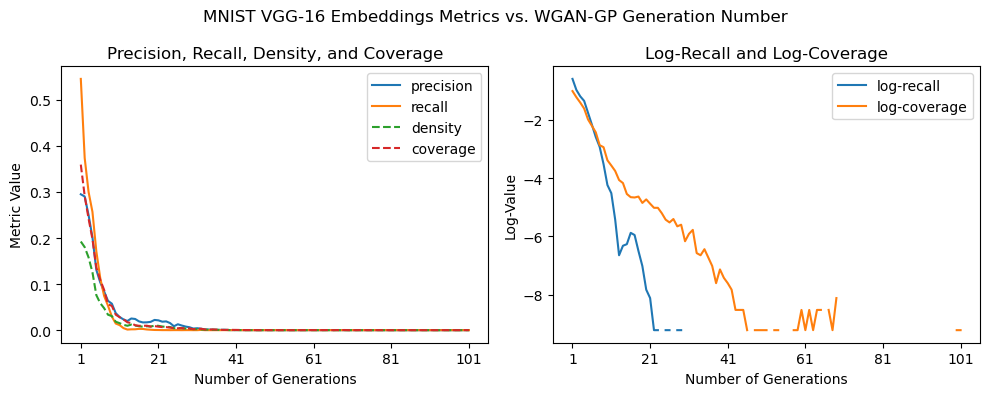

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,4))

ax[0].plot(precision, label='precision')
ax[0].plot(recall, label='recall')
ax[0].plot(density, label='density', linestyle='dashed')
ax[0].plot(coverage, label='coverage', linestyle='dashed')
ax[0].set_title('Precision, Recall, Density, and Coverage')
ax[0].set_ylabel('Metric Value')
ax[0].legend()
xaxis_wrt_generation(ax[0])

#ax[1].plot(np.log(precision), label='log precision')
ax[1].plot(np.log(recall), label='log-recall')
#ax[1].plot(np.log(density), label='log density', linestyle='dashed')
ax[1].plot(np.log(coverage), label='log-coverage')#, linestyle='dashed')
ax[1].set_title('Log-Recall and Log-Coverage')
ax[1].legend()
ax[1].set_xlabel('Number of Generations')
ax[1].set_ylabel('Log-Value')

fig.suptitle(f'MNIST VGG-16 Embeddings Metrics vs. {"WGAN-GP" if model_type=="wgan_gp" else "Diffusion"} Generation Number')
fig.tight_layout()

/tmp/ipykernel_2740121/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1


Text(0.5, 1.0, 'MNIST VGG-16 Embeddings Metrics vs.\nWGAN-GP Generation Number')

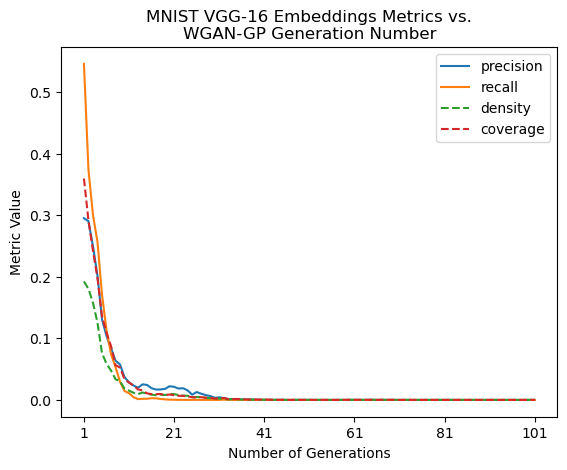

In [118]:
fig, ax = plt.subplots()
ax.plot(precision, label='precision')
ax.plot(recall, label='recall')
ax.plot(density, label='density', linestyle='dashed')
ax.plot(coverage, label='coverage', linestyle='dashed')
ax.set_title('Precision, Recall, Density, and Coverage')
ax.set_ylabel('Metric Value')
ax.legend()
xaxis_wrt_generation(ax)

ax.set_title(f'MNIST VGG-16 Embeddings Metrics vs.\n{"WGAN-GP" if model_type=="wgan_gp" else "Diffusion"} Generation Number')

/tmp/ipykernel_2740121/2097973614.py:3: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(recall), label='log-recall')
/tmp/ipykernel_2740121/2097973614.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(coverage), label='log-coverage')#, linestyle='dashed')
/tmp/ipykernel_2740121/2707125598.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1


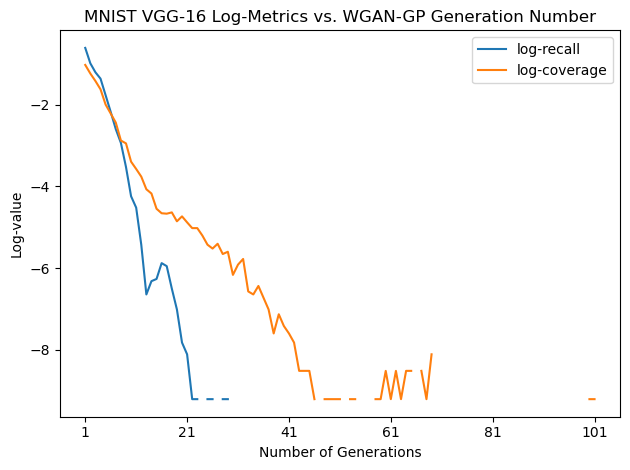

In [124]:
fig, ax = plt.subplots()

ax.plot(np.log(recall), label='log-recall')
ax.plot(np.log(coverage), label='log-coverage')#, linestyle='dashed')
ax.set_title('Log-Recall and Log-Coverage')
ax.set_ylabel('Log-value')
ax.legend()
xaxis_wrt_generation(ax)

ax.set_title(f'MNIST VGG-16 Log-Metrics vs. {"WGAN-GP" if model_type=="wgan_gp" else "Diffusion"} Generation Number')
fig.tight_layout()